# STOCK-PREDICTION

In [38]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
#import talib
import yfinance as yf

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Feature engineering
from sklearn.feature_selection import SelectKBest, f_classif

# Time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model evaluation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
sns.set(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)


# 1. Data Exploration:


In [39]:
#ETF data loading
csv_path="C:\\Users\\vavil\\Desktop\\stocks\\ADSK.csv"
etf_data= pd.read_csv(csv_path)

In [40]:
print(etf_data.head())

         Date      Open      High       Low     Close  Adj Close    Volume
0  1985-06-28  0.000000  0.510417  0.500000  0.500000   0.436705  14728800
1  1985-07-01  0.500000  0.510417  0.500000  0.500000   0.436705   6511200
2  1985-07-02  0.520833  0.531250  0.520833  0.520833   0.454901   2380800
3  1985-07-03  0.520833  0.531250  0.520833  0.520833   0.454901   1317600
4  1985-07-05  0.531250  0.541667  0.531250  0.531250   0.463999   1128000


In [41]:
print(etf_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8761 non-null   object 
 1   Open       8761 non-null   float64
 2   High       8761 non-null   float64
 3   Low        8761 non-null   float64
 4   Close      8761 non-null   float64
 5   Adj Close  8761 non-null   float64
 6   Volume     8761 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 479.2+ KB
None


In [42]:
print(etf_data.describe())

              Open         High          Low        Close    Adj Close  \
count  8761.000000  8761.000000  8761.000000  8761.000000  8761.000000   
mean     30.531546    30.974430    30.092111    30.555787    30.334617   
std      38.801425    39.289654    38.301994    38.831054    38.966945   
min       0.000000     0.510417     0.500000     0.500000     0.436705   
25%       6.171875     6.312500     6.031250     6.187500     5.668753   
50%      10.812500    11.031250    10.587500    10.781250    10.276823   
75%      40.000000    40.560001    39.509998    40.080002    40.080002   
max     210.440002   211.580002   208.639999   210.759995   210.759995   

             Volume  
count  8.761000e+03  
mean   2.890154e+06  
std    2.346974e+06  
min    1.200000e+04  
25%    1.574900e+06  
50%    2.383000e+06  
75%    3.505400e+06  
max    4.979440e+07  


# 2. Adding Features

In [43]:
etf_data.dropna(inplace=True)

In [44]:
# Adding a coloumn for price change
etf_data['PriceChange'] = etf_data['Close'].pct_change() * 100
print(etf_data.head())

         Date      Open      High       Low     Close  Adj Close    Volume  \
0  1985-06-28  0.000000  0.510417  0.500000  0.500000   0.436705  14728800   
1  1985-07-01  0.500000  0.510417  0.500000  0.500000   0.436705   6511200   
2  1985-07-02  0.520833  0.531250  0.520833  0.520833   0.454901   2380800   
3  1985-07-03  0.520833  0.531250  0.520833  0.520833   0.454901   1317600   
4  1985-07-05  0.531250  0.541667  0.531250  0.531250   0.463999   1128000   

   PriceChange  
0          NaN  
1     0.000000  
2     4.166663  
3     0.000000  
4     2.000004  


In [45]:
# creating a feature to address price increase or decrease with binary representation(increasing-1, decreasing-0)
etf_data['PriceMovement'] = (etf_data['PriceChange'] > 0).astype(int)
print(etf_data.head())

         Date      Open      High       Low     Close  Adj Close    Volume  \
0  1985-06-28  0.000000  0.510417  0.500000  0.500000   0.436705  14728800   
1  1985-07-01  0.500000  0.510417  0.500000  0.500000   0.436705   6511200   
2  1985-07-02  0.520833  0.531250  0.520833  0.520833   0.454901   2380800   
3  1985-07-03  0.520833  0.531250  0.520833  0.520833   0.454901   1317600   
4  1985-07-05  0.531250  0.541667  0.531250  0.531250   0.463999   1128000   

   PriceChange  PriceMovement  
0          NaN              0  
1     0.000000              0  
2     4.166663              1  
3     0.000000              0  
4     2.000004              1  


In [46]:
print(etf_data.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'PriceChange', 'PriceMovement'],
      dtype='object')


In [47]:
# Exclude non-numeric columns from features
numeric_columns = etf_data.select_dtypes(include='number').columns
X = etf_data[numeric_columns].drop('PriceMovement', axis=1)  # Assuming 'PriceMovement' is the target variable
y = etf_data['PriceMovement']

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Machine Learning Model Selection and Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9994295493439818


1. RandomForest models provide feature importance scores. 
2. Analyze these scores to understand which features have the most significant impact on the model's predictions.

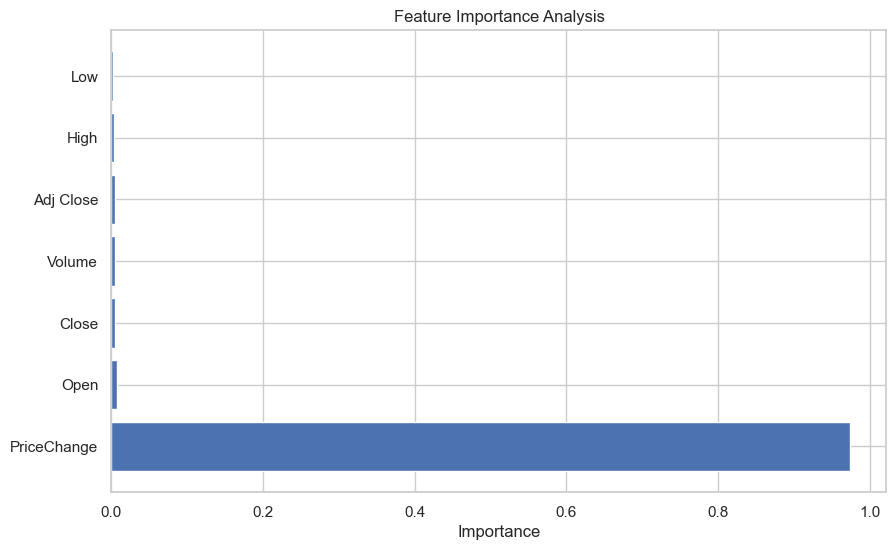

In [48]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_imputed, y)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X_imputed.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance Analysis')
plt.show()

# Terms:

# Simple Moving Average (SMA_20):

Definition: The Simple Moving Average is a widely used indicator that calculates the average price of a security over a specified number of periods.
Calculation: For the SMA_20 column, it represents the 20-day Simple Moving Average of the closing prices. It is calculated by taking the average of the closing prices over the last 20 trading days.

# Exponential Moving Average (EMA_12):

Definition: The Exponential Moving Average is a type of moving average that gives more weight to recent prices, making it more responsive to price changes than a simple moving average.

Calculation: For the EMA_12 column, it represents the 12-day Exponential Moving Average of the closing prices. It is calculated using an exponential smoothing formula that assigns more weight to recent prices.

# Relative Strength Index (RSI_14):

Definition: The Relative Strength Index is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and is typically used to identify overbought or oversold conditions in a market.

Calculation: For the RSI_14 column, it represents the 14-day Relative Strength Index. It is calculated based on the average gain and average loss over the last 14 trading days.

SMA_20: Smoothed average of the closing prices over the last 20 days.

EMA_12: Weighted average of the closing prices, with more weight given to recent prices (last 12 days).

RSI_14: Momentum oscillator measuring the speed and change of price movements over the last 14 days.

These indicators are commonly used in technical analysis to gain insights into price trends, momentum, and potential reversal points in financial markets. Traders and analysts often use them in combination to make more informed decisions about buying or selling securities.# 

# MACD
MACD stands for Moving Average Convergence Divergence, and it is a popular momentum indicator used in technical analysis to analyze and identify potential trends in a stock's price movement. It consists of three components: the MACD line, the signal line, and the histogram.

MACD Line (Fast Line):

The MACD line is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. The resulting line is referred to as the "fast line" or "MACD line."
Signal Line (Slow Line):

The signal line is a 9-period EMA of the MACD line. It is often called the "slow line" or "signal line." The signal line is used to generate trading signals and smooth out the MACD line.
Histogram:

The histogram is the vertical bars that represent the difference between the MACD line and the signal line. When the MACD line is above the signal line, the histogram is positive, indicating potential bullish momentum. Conversely, when the MACD line is below the signal line, the histogram is negative, indicating potential bearish momentum.
Interpretation:
Crossovers:

Bullish Signal: When the MACD line crosses above the signal line, it generates a bullish signal, suggesting potential upward momentum.
Bearish Signal: When the MACD line crosses below the signal line, it generates a bearish signal, suggesting potential downward momentum.
Divergence:

Bullish Divergence: When the price makes new lows, but the MACD does not, it can signal a potential reversal to the upside.
Bearish Divergence: When the price makes new highs, but the MACD does not, it can signal a potential reversal to the downside.
Histogram:

The histogram helps visualize the difference between the MACD line and the signal line. Positive values indicate potential upward momentum, while negative values indicate potential downward momentum.
Traders and analysts use the MACD to identify trends, confirm trend reversals, and generate buy or sell signals. It is a versatile tool that provides insights into the strength and direction of price trends in a financial instrument.

In [49]:
# Define the ETF symbol and date range
etf_symbol = "SPY"  # Replace with your ETF symbol
start_date = "2022-01-03"
end_date = "2023-01-01"

# Fetch historical ETF data using yfinance
etf_data = yf.download(etf_symbol, start=start_date, end=end_date)

# Calculate Simple Moving Average (SMA) with a window of 20 days
etf_data['SMA_20'] = etf_data['Close'].rolling(window=20, min_periods=1).mean()

# Calculate Exponential Moving Average (EMA) with a span of 12 days
etf_data['EMA_12'] = etf_data['Close'].ewm(span=12, adjust=False).mean()

# Calculate Exponential Moving Average (EMA) with a span of 12 days
etf_data['EMA_12'] = etf_data['Close'].ewm(span=12, adjust=False).mean()

# Calculate Relative Strength Index (RSI) with a window of 14 days
delta = etf_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()

rs = avg_gain / avg_loss
etf_data['RSI_14'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
etf_data['EMA_26'] = etf_data['Close'].ewm(span=26, adjust=False).mean()
etf_data['EMA_12'] = etf_data['Close'].ewm(span=12, adjust=False).mean()
etf_data['MACD'] = etf_data['EMA_12'] - etf_data['EMA_26']
etf_data['Signal_Line'] = etf_data['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Bollinger Bands
etf_data['Rolling_Mean'] = etf_data['Close'].rolling(window=20).mean()
etf_data['Upper_Band'] = etf_data['Rolling_Mean'] + 2 * etf_data['Close'].rolling(window=20).std()
etf_data['Lower_Band'] = etf_data['Rolling_Mean'] - 2 * etf_data['Close'].rolling(window=20).std()

# Drop rows with NaN values
etf_data = etf_data.dropna()

# Display the data with added features
print(etf_data[['Close', 'SMA_20', 'EMA_12', 'RSI_14', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band']].head())

[*********************100%%**********************]  1 of 1 completed
                 Close      SMA_20      EMA_12     RSI_14      MACD  \
Date                                                                  
2022-01-31  449.910004  455.848000  446.599423  38.539514 -9.501387   
2022-02-01  452.950012  454.610001  447.576437  37.436441 -8.290981   
2022-02-02  457.350006  453.600002  449.080063  40.234330 -6.897176   
2022-02-03  446.600006  452.511002  448.698515  37.925931 -6.584113   
2022-02-04  448.700012  451.549002  448.698746  39.482676 -6.096282   

            Signal_Line  Upper_Band  Lower_Band  
Date                                             
2022-01-31    -8.534214  486.624909  425.071091  
2022-02-01    -8.485567  483.625731  425.594270  
2022-02-02    -8.167889  480.589074  426.610929  
2022-02-03    -7.851134  478.735862  426.286142  
2022-02-04    -7.500164  476.783654  426.314350  


# 3. Binary Target variable
A binary target variable, also known as a binary outcome or response variable, is a categorical variable with two possible outcomes or classes. In the context of stock price prediction, a binary target variable is typically used for binary classification tasks, where the goal is to predict whether a certain event will occur or not.

In the specific case of predicting stock price movements, the binary target variable is often defined based on the direction of the price change. Here's a common way to define it:

Binary Target Variable for Stock Price Movement:
Assign a value of 1 if the stock price is expected to go up in the future (e.g., on the next trading day).
Assign a value of 0 if the stock price is expected to stay the same or go down in the future.
This binary classification approach simplifies the problem into predicting the direction of price movement rather than predicting the exact price value. It is common to use technical indicators, historical price data, and other relevant features as inputs to machine learning models to make predictions about the future direction of stock prices.

In the code provided earlier for stock prediction, the binary target variable 'Price_Up' is created using this concept. It takes the value of 1 if the closing price on the next day is higher than the current day, and 0 otherwise. The machine learning model is then trained to predict this binary outcome.


In [50]:
# Create binary target variable
etf_data['Price_Up'] = (etf_data['Close'].shift(-1) > etf_data['Close']).astype(int)

# Drop rows with NaN values
etf_data = etf_data.dropna()

# Define features and target
features = ['SMA_20', 'EMA_12', 'RSI_14', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band']
target = 'Price_Up'

# Split the data
X_train, X_test, y_train, y_test = train_test_split(etf_data[features], etf_data[target], test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
predictions = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.46808510638297873
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56        29
           1       0.32      0.33      0.32        18

    accuracy                           0.47        47
   macro avg       0.44      0.44      0.44        47
weighted avg       0.47      0.47      0.47        47



In [51]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Make predictions using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print("Test Accuracy:", accuracy)
print("Classification Report:")
print(report)

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best Accuracy: 0.5842587696104354
Test Accuracy: 0.5106382978723404
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.66      0.62        29
           1       0.33      0.28      0.30        18

    accuracy                           0.51        47
   macro avg       0.46      0.47      0.46        47
weighted avg       0.49      0.51      0.50        47



->The param_grid dictionary defines the hyperparameters and the ranges to search over.

->GridSearchCV performs the grid search with cross-validation, and cv specifies the number of folds for cross-validation.

->The best hyperparameters and the corresponding accuracy are printed.

->The best model is then used to make predictions on the test set, and its performance is evaluated.

->Feel free to adjust the param_grid values based on your specific needs. Additionally, you can explore other hyperparameter tuning techniques or try different algorithms for comparison.


# 4. The factors influencing stock price movements

In [52]:
# Extract feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

       Feature  Importance
2       RSI_14    0.180681
0       SMA_20    0.155233
4  Signal_Line    0.147158
6   Lower_Band    0.139434
3         MACD    0.133681
5   Upper_Band    0.132405
1       EMA_12    0.111406


# 5. Stochastic Oscillator
The Stochastic Oscillator is a popular momentum indicator used in technical analysis to assess the relative position of a security's closing price within its price range over a specified period. Developed by George C. Lane in the late 1950s, the Stochastic Oscillator helps traders and analysts identify potential overbought or oversold conditions, as well as potential trend reversals.

Traders and analysts use the Stochastic Oscillator in conjunction with other technical indicators and chart patterns to make informed decisions about potential entry or exit points in the market. It's important to note that, like any indicator, the Stochastic Oscillator is not foolproof and should be used in conjunction with other analysis techniques for a comprehensive view of market conditions.

[*********************100%%**********************]  1 of 1 completed


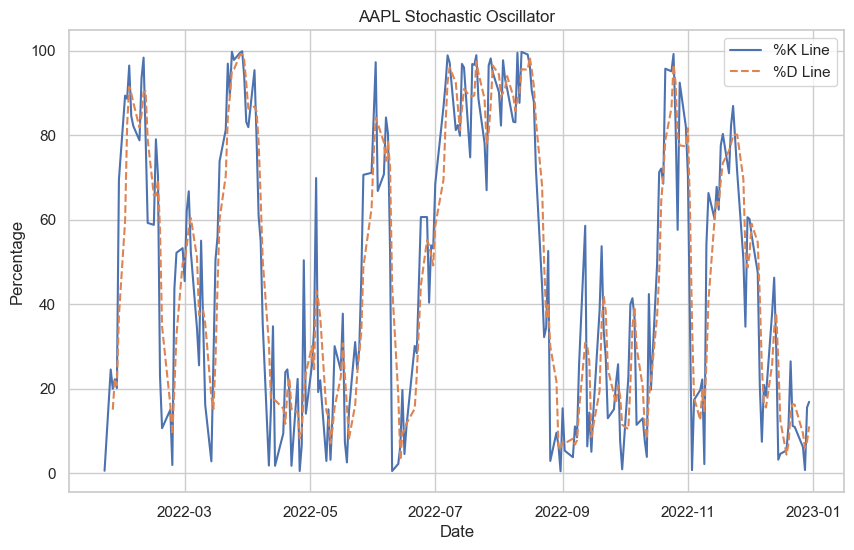

In [53]:
def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    # Calculate the %K line
    data['Lowest_Low'] = data['Low'].rolling(window=k_period).min()
    data['Highest_High'] = data['High'].rolling(window=k_period).max()
    data['%K'] = ((data['Close'] - data['Lowest_Low']) / (data['Highest_High'] - data['Lowest_Low'])) * 100

    # Calculate the %D line
    data['%D'] = data['%K'].rolling(window=d_period).mean()

    # Drop temporary columns
    data = data.drop(['Lowest_Low', 'Highest_High'], axis=1)

    return data

# Download historical stock data
symbol = "AAPL"
start_date = "2022-01-01"
end_date = "2023-01-01"
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Calculate Stochastic Oscillator
stock_data = calculate_stochastic_oscillator(stock_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stock_data['%K'], label='%K Line')
plt.plot(stock_data['%D'], label='%D Line', linestyle='--')
plt.title(f"{symbol} Stochastic Oscillator")
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.legend()
plt.show()

# Feature integration

In [54]:
# Download historical stock data
symbol = "AAPL"
start_date = "2022-01-01"
end_date = "2023-01-01"
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Calculate Stochastic Oscillator
stock_data = calculate_stochastic_oscillator(stock_data)

# Assume you have a target variable 'Price_Movement' indicating 1 for increase, 0 for decrease
# You should replace this with your actual target variable
stock_data['Price_Movement'] = stock_data['Close'].pct_change().shift(-1) > 0

# Drop rows with NaN values introduced by the Stochastic Oscillator calculation
stock_data = stock_data.dropna()

# Display the updated dataset with Stochastic Oscillator features
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-25  158.979996  162.759995  157.020004  159.779999  157.975021   
2022-01-26  163.500000  164.389999  157.820007  159.690002  157.886017   
2022-01-27  162.449997  163.839996  158.279999  159.220001  157.421341   
2022-01-28  165.710007  170.350006  162.800003  170.330002  168.405838   
2022-01-31  170.160004  175.000000  169.509995  174.779999  172.805573   

               Volume         %K         %D  Price_Movement  
Date                                                         
2022-01-25  115798400  19.945040  14.994075           False  
2022-01-26  108275300  22.197538  22.215605           False  
2022-01-27  121954600  20.106784  20.749787            True  
2022-01-28  179935700  69.528505  37.277609            True  
2022-01-31  115541600  89.323869  59.653

# 6. Data Splitting

In [55]:
# Assuming your DataFrame is named 'stock_data'
# Features (X) are columns excluding the target variable, and the target variable (y)
features = stock_data.drop(['Price_Movement'], axis=1)  # Adjust this based on your actual columns
target = stock_data['Price_Movement']

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
# You can adjust the 'test_size' parameter based on your preference
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (188, 8) (188,)
Testing set shape: (48, 8) (48,)


# Using the features of MinMax scaler and Standard Scaler.
It looks like the features have been successfully scaled using either MinMaxScaler or StandardScaler. Here are a few observations based on the displayed data:

MinMaxScaler (or StandardScaler) Effect: The values for each feature have been scaled to a specific range. For MinMaxScaler,this range is typically between 0 and 1, while StandardScaler standardizes the data with a mean of 0 and a standard deviation of 1. 

Consistent Transformation: The scaling parameters learned from the training set have been applied consistently to both the training and testing sets. This ensures that the model is exposed to similar scaled features during both training and evaluation.

Feature Range: Features like "Volume" or "%D" have values within a specific range, and this ensures that no single feature dominates the others due to different scales.

In [56]:
# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler()

# Fit and transform the scaler on the training set features
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the testing set features using the same scaler
X_test_scaled = min_max_scaler.transform(X_test)

# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Fit and transform the scaler on the training set features
X_train_scaled = standard_scaler.fit_transform(X_train)

# Transform the testing set features using the same scaler
X_test_scaled = standard_scaler.transform(X_test)

In [57]:
# Display the first few rows of the scaled training set features
print("Scaled Training Set Features:")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())

# Display the first few rows of the scaled testing set features
print("\nScaled Testing Set Features:")
print(pd.DataFrame(X_test_scaled, columns=X_test.columns).head())

Scaled Training Set Features:
       Open      High       Low     Close  Adj Close    Volume        %K  \
0  1.088268  0.991581  1.159705  1.089267   1.116546 -1.481510 -0.435657   
1 -0.446804 -0.546030 -0.405503 -0.440033  -0.411999 -0.711649  0.348521   
2  0.492232  0.378318  0.133234 -0.000021   0.013677  1.561649 -1.295035   
3 -1.936089 -2.012351 -2.058376 -2.212017  -2.209049 -0.084224 -1.466375   
4 -0.760084 -0.919497 -1.076534 -1.230145  -1.231780  0.055501 -0.886009   

         %D  
0 -0.384212  
1  0.091795  
2 -0.604435  
3 -1.382674  
4 -0.866984  

Scaled Testing Set Features:
       Open      High       Low     Close  Adj Close    Volume        %K  \
0  0.473757  0.859530  0.602637  0.969120   0.956752  0.924844  0.644936   
1 -0.225901 -0.314335 -0.291540 -0.357282  -0.348037  0.037648  1.037338   
2 -1.508742 -0.994839 -1.380970 -0.863335  -0.860398  1.144518 -0.194037   
3  1.533286  1.464691  1.534271  1.417884   1.409816 -0.446280  0.917175   
4  0.257674  0.1433

In [58]:
# Initialize the Random Forest Classifier
random_forest_model = RandomForestClassifier(random_state=42)

# Train the model on the scaled training set
random_forest_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled testing set
y_pred_rf = random_forest_model.predict(X_test_scaled)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

# Display evaluation metrics for Random Forest
print("Random Forest Model:")
print("Accuracy:", accuracy_rf)
print("\nConfusion Matrix:\n", conf_matrix_rf)
print("\nClassification Report:\n", classification_rep_rf)

Random Forest Model:
Accuracy: 0.5208333333333334

Confusion Matrix:
 [[16 16]
 [ 7  9]]

Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.50      0.58        32
        True       0.36      0.56      0.44        16

    accuracy                           0.52        48
   macro avg       0.53      0.53      0.51        48
weighted avg       0.58      0.52      0.53        48



# Random forest classifier

In [59]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
random_forest_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5)

# Perform Grid Search on the training set
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [60]:
imputer = SimpleImputer(strategy='mean')  # You can choose another strategy if needed

# Fit and transform the imputer on your training data
X_train_imputed = imputer.fit_transform(X_train)

# Transform the imputer on your testing data
X_test_imputed = imputer.transform(X_test)

# Train the model on the imputed data
final_model.fit(X_train_imputed, y_train)

# Make predictions on the imputed testing set
y_pred_final = final_model.predict(X_test_imputed)

# Assuming X_train_imputed, X_test_imputed, y_train, y_test are the imputed datasets
# Initialize the Random Forest model with the best hyperparameters
final_model = RandomForestClassifier(random_state=42, **best_params)

# Train the model on the imputed training set
final_model.fit(X_train_imputed, y_train)

# Make predictions on the imputed testing set
y_pred_final = final_model.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_final)
conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

# Display evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.4583333333333333

Confusion Matrix:
 [[13 19]
 [ 7  9]]

Classification Report:
               precision    recall  f1-score   support

       False       0.65      0.41      0.50        32
        True       0.32      0.56      0.41        16

    accuracy                           0.46        48
   macro avg       0.49      0.48      0.45        48
weighted avg       0.54      0.46      0.47        48



# The Predictions

In [61]:
# Assuming your DataFrame is named 'etf_data'
etf_data['prediction_label'] = ''

# Adding labels based on actual target variable 'Price_Up'
for index, row in etf_data.iterrows():
    if row['Price_Up'] == 1:
        etf_data.at[index, 'prediction_label'] = "the stock price goes up"
    elif row['Price_Up'] == 0:
        etf_data.at[index, 'prediction_label'] = "the stock price goes down"
    else:
        etf_data.at[index, 'prediction_label'] = "can't predict"

# Display the DataFrame with the new prediction labels
print(etf_data[['Price_Up', 'prediction_label']])


            Price_Up           prediction_label
Date                                           
2022-01-31         1    the stock price goes up
2022-02-01         1    the stock price goes up
2022-02-02         0  the stock price goes down
2022-02-03         1    the stock price goes up
2022-02-04         0  the stock price goes down
...              ...                        ...
2022-12-23         0  the stock price goes down
2022-12-27         0  the stock price goes down
2022-12-28         1    the stock price goes up
2022-12-29         0  the stock price goes down
2022-12-30         0  the stock price goes down

[232 rows x 2 columns]
